### Goals: 
Regional Uncertainty test, this time on dataset with NIR unperturbed

In [2]:
#from auxiliary import GetHDI, PlotDist, GetDistrib
from obpgpyutils.LittleHelpers.auxiliary import GetHDI, PlotDist, GetDistrib
from obpgpyutils.LxReader.readers import CL3bReader
from matplotlib.pylab import rcParams
import matplotlib.pyplot as pl
import os
import pandas as pd
import numpy as np
import seaborn as sb

In [3]:
rcParams['xtick.labelsize']=16
rcParams['ytick.labelsize']=16
% matplotlib inline

In [4]:
# DATA STUFF
dataDir = '/accounts/ekarakoy/disk02/UNCERTAINTIES/Monte-Carlo/SWF/DATA/L2_L3/GLOBAL/VisOnly/'
fname = 'S20031932003196.L3b_4D_SU5.nc'
fp = os.path.join(dataDir,fname)

In [5]:
bands = ['412','443','490','510','555','670']
prodlist = ['Rrs_unc_%s' % band for band in bands ]
regions ='all'

In [6]:
myl3 = CL3bReader(fp, prodlist, regions='all')

In [7]:
# PLOT SUMMARY UNCERTAINTY GRAPHS FOR EA. REGION
def PlotSummaryUncertainty(regs=['deep','eutr','meso','olig'],
                            bands=['412','443','490','510','555','670'],
                          alpha=0.95):
    # Prep Dicts with Summary data for plotting
    regKeys = regs + ['all']
    wtdMeanDict = dict.fromkeys(regKeys)
    hdiLoDict = dict.fromkeys(regKeys)
    hdiHiDict = dict.fromkeys(regKeys)
    for reg in regKeys:
        wtdMeanDict[reg] = dict.fromkeys(bands)
        hdiLoDict[reg] = dict.fromkeys(bands)
        hdiHiDict[reg] = dict.fromkeys(bands)
    # Fill Dicts
    for reg in regKeys:
        for band in bands:
            distDict = {}
            hdiDict = {}
            if reg == 'all': 
                tempArr = myl3.productDict['Rrs_unc_%s' % band]
            else:
                tempArr = myl3.productDict['Rrs_unc_%s' % band][myl3.regionMaskDict[reg]]
            # Get distribution parameters
            distDict = GetDistrib(tempArr)
            cnt, wid, cen = distDict['counts'], distDict['widths'], distDict['centers']
            # getHDI
            hdiDict = GetHDI(cnt, binWidth=wid,credMass=alpha)
            wtdCounts = cnt * wid
            hdiLims=cen[hdiDict['hdiIndices'].min()],cen[hdiDict['hdiIndices'].max()]
            wtdMeanDict[reg][band] = np.sum(wtdCounts*cen/wtdCounts.sum())
            hdiLoDict[reg][band],hdiHiDict[reg][band] = min(hdiLims),max(hdiLims)
    # Convert Dictionaries to PANDAS DataFrames:
    wmdf = pd.DataFrame(wtdMeanDict)
    hdiLodf = pd.DataFrame(hdiLoDict)
    hdiHidf = pd.DataFrame(hdiHiDict)
    # DO THE PLOTTING ------------------
    f,axs = pl.subplots(nrows=2,ncols=2,figsize=(16,12))
    bandnum = [int(band) for band in bands]
    # Compare 'all', with each other masking
    regs = ['deep','eutr','meso','olig']
    f.suptitle('Uncertainty by Region for %s' %fname,fontsize=20)
    for ax,reg in zip (axs.ravel(),regs):
        percCov = myl3.regionMaskDict[reg].sum()/myl3.regionMaskDict[reg].size * 100
        ax.set_title('%s ( %.2f%% Coverage)' % (reg.upper(), percCov), fontsize=18)
        means = np.array(wmdf.loc[bands,'all'])
        hiy = np.array(hdiHidf.loc[bands,'all'])
        loy = np.array(hdiLodf.loc[bands,'all'])
        ax.plot(bands,wmdf.loc[bands,'all'],'k',lw=2,label='weighted mean; all')
        ax.plot(bands,wmdf.loc[bands,reg],'red',lw=2,label='weighted mean; %s' %reg)
        ax.fill_between(bandnum,y1=hdiHidf.loc[bands,'all'],
                        y2=hdiLodf.loc[bands,'all'],color='k',alpha=0.5,
                        label='95% HDI (all)')
        ax.fill_between(bandnum,y1=hdiHidf.loc[bands,reg],
                        y2=hdiLodf.loc[bands,reg],color='red',alpha=0.2,
                        label='95%% HDI (%s)' % reg)
        ax.ticklabel_format(style='sci',scilimits=(-2,3),axis='y')
        ax.legend(loc='best',fontsize=16)
    f.savefig('UncertaintyByRegion_Global_%s.png' % fname,format='png')

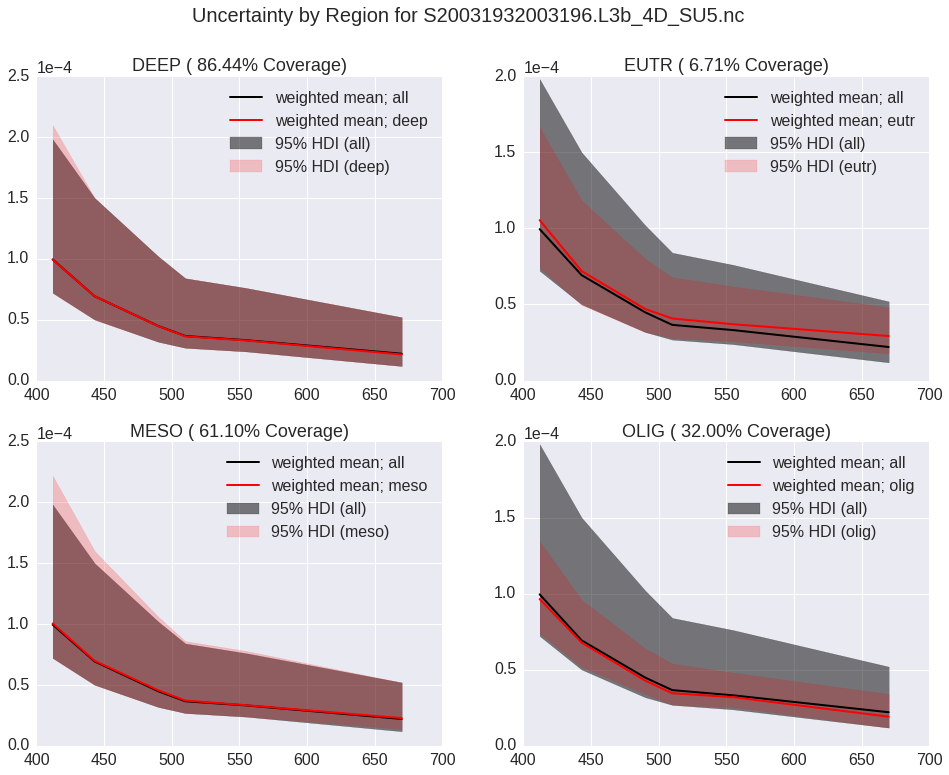

In [8]:
PlotSummaryUncertainty()

In [9]:
def PlotShadedDists(distDict,hdiDict,**kwargs):
    ax = kwargs.pop('ax',None)
    credmass = kwargs.pop('credmass',0.95)
    xlim = kwargs.pop('xlim',None)
    datalabel = kwargs.pop('datalabel','None')
    wtdData = distDict['counts'] * distDict['widths']
    if not ax:
        f = pl.figure(figsize=(10,10))
        ax = f.add_subplot(111)
    if not xlim:
        xlim = distDict['edges'].min(),distDict['edges'].max()
    PlotDist(wtdData, distDict['centers'], distDict['widths'], ax, xlim=xlim,
            hdiDict=hdiDict,dataname=datalabel,hdicolor='brown',datacolor='orange')

In [10]:
# PLOT DISTRIBUTION AND 95% HDIs for each band in groups of 4

In [11]:
def PlotUnmaskedDataDist(band,xlims=(0,8e-4),alpha=0.95):
    distDict,hdiDict = {},{}
    # ------- all data --------------
    datalbl = 'Rrs_unc_%s' % BAND
    data = myl3.productDict[datalbl]
    data=data[np.logical_and(data>=xlims[0],data<=xlims[1])]
    distDict = GetDistrib(data)
    cnt, wid = distDict['counts'], distDict['widths']
    hdiDict = GetHDI(cnt, binWidth=wid,credMass=alpha)
    fall = pl.figure(figsize=(8,5))
    ax = fall.add_subplot(111)
    PlotShadedDists(distDict,hdiDict,ax=ax,xlim=xlims,datalabel=datalbl + ', all regions')
    ax.ticklabel_format(style='sci',scilimits=(-2,3),axis='both')
    return fall,ax

def PlotDataDistByReg(band, **kwargs):
    regs = kwargs.pop('regs',['eutr','olig','deep','meso'])
    xlims = kwargs.pop('xlims', (0,8e-4))
    alpha = kwargs.pop('alpha', 0.95)
    f,axs = pl.subplots(nrows=2, ncols=2, figsize=(15,9))
    datalbl = 'Rrs_unc_%s' % BAND
    for ax, reg in zip(axs.ravel(), regs):
        data = myl3.productDict['Rrs_unc_%s' % BAND][myl3.regionMaskDict[reg]]
        data = data[np.logical_and(data>=xlims[0],data<=xlims[1])]
        distDict = GetDistrib(data)
        cnt, wid = distDict['counts'], distDict['widths']
        hdiDict = GetHDI(cnt, binWidth=wid,credMass=alpha)
        PlotShadedDists(distDict,hdiDict,ax=ax,xlim=xlims,datalabel='%s_%s' %(datalbl,reg))
        ax.ticklabel_format(style='sci',scilimits=(-2,3),axis='both')
    return f,axs

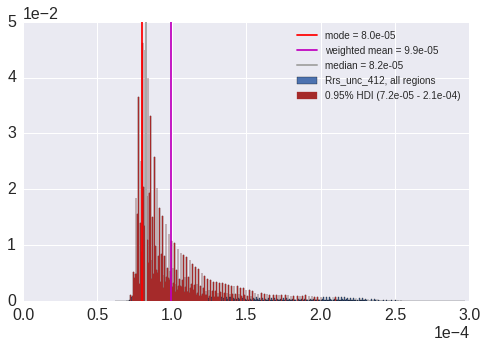

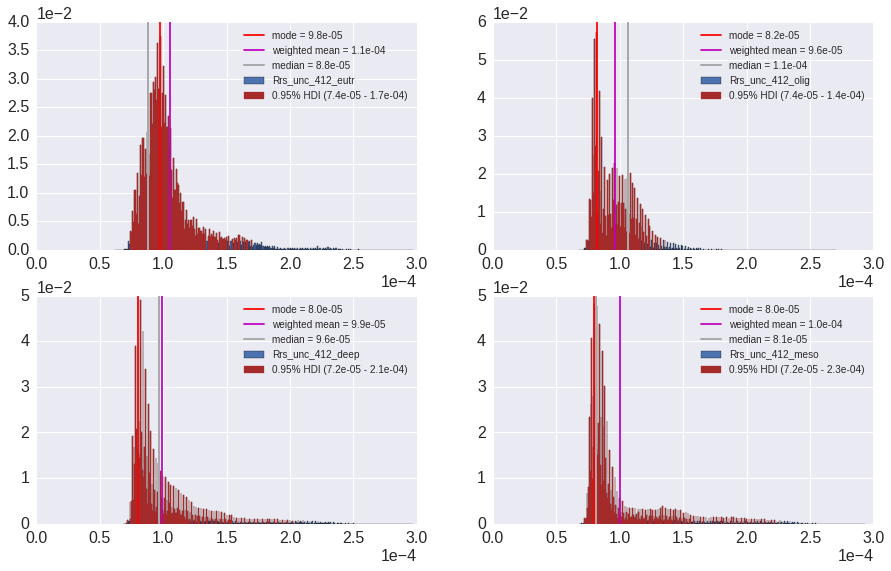

In [13]:
BAND=412
xlims=(0,3e-4)
f1, ax1 = PlotUnmaskedDataDist(BAND,xlims=xlims)
f2, axs2 = PlotDataDistByReg(BAND,xlims=xlims)

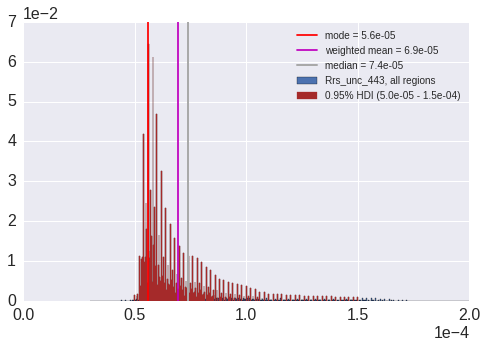

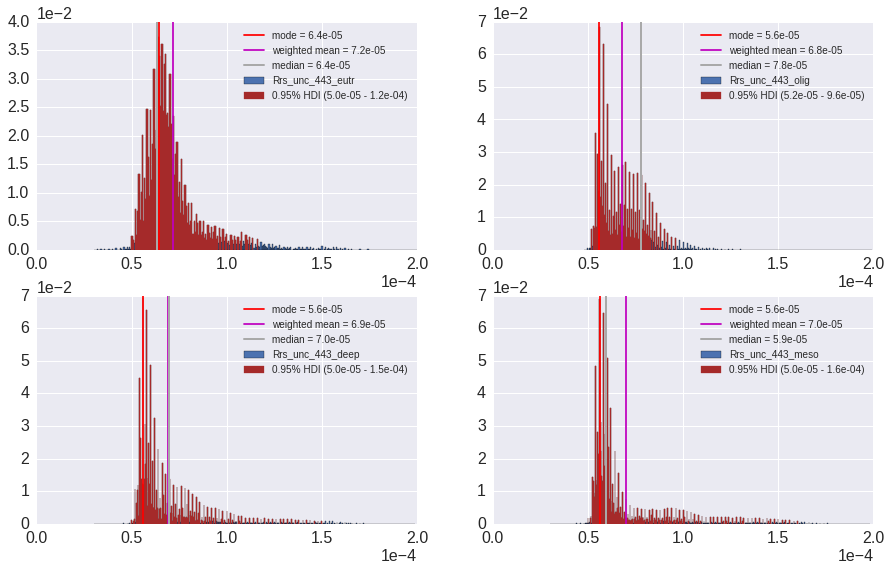

In [14]:
BAND=443
xlims=(0,2e-4)
f1, ax1 = PlotUnmaskedDataDist(BAND,xlims=xlims)
f2, axs2 = PlotDataDistByReg(BAND,xlims=xlims)

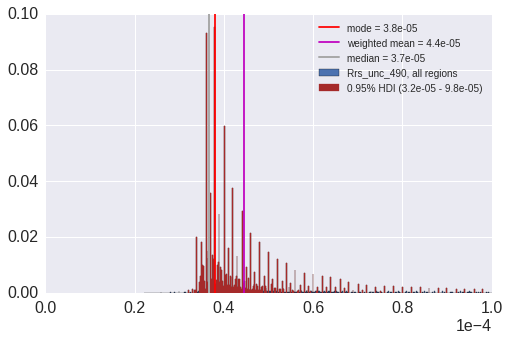

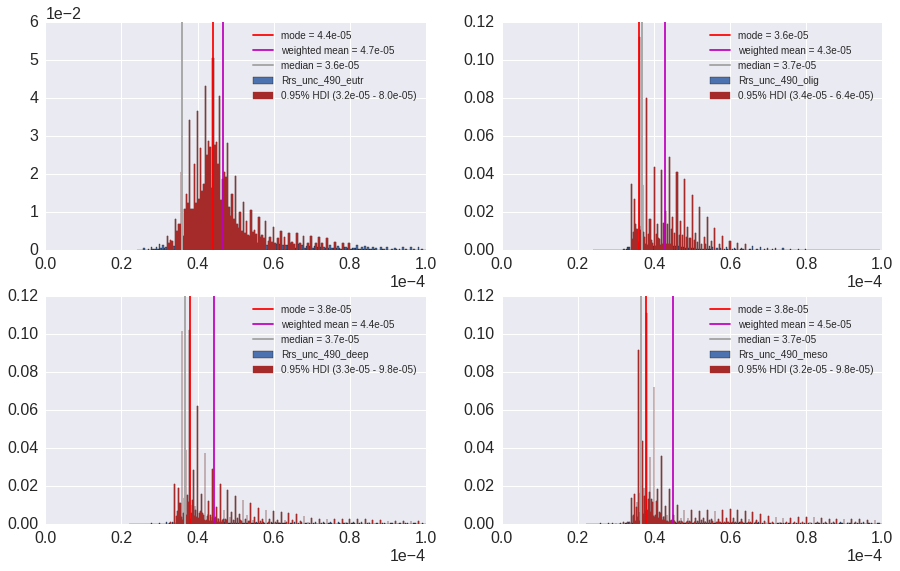

In [15]:
BAND=490
xlims=(0,1e-4)
f1, ax1 = PlotUnmaskedDataDist(BAND, xlims=xlims)
f2, axs2 = PlotDataDistByReg(BAND, xlims=xlims)

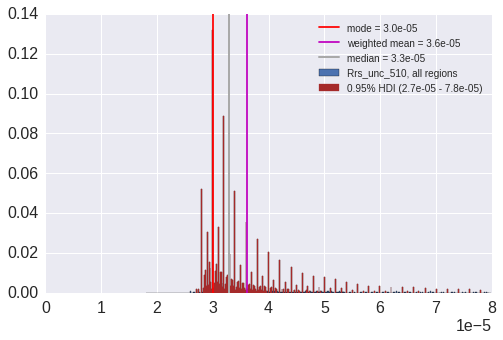

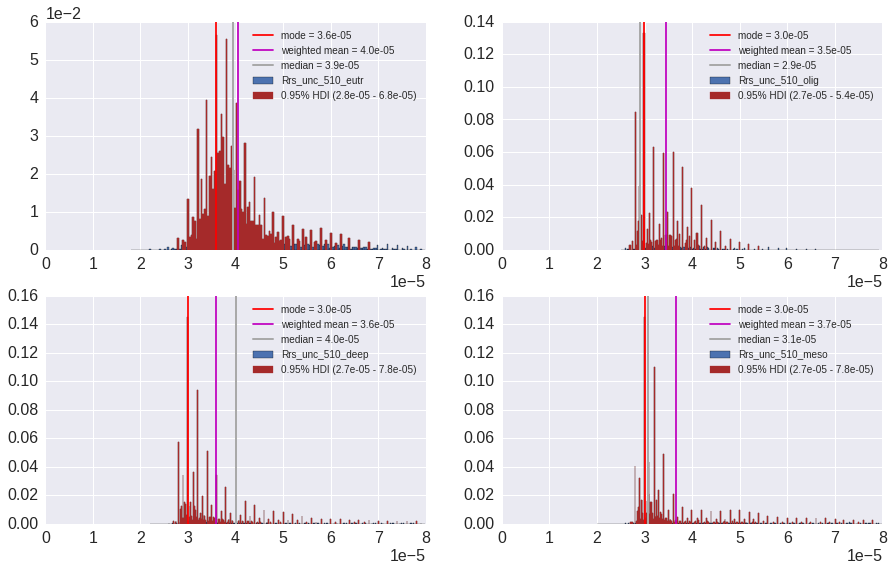

In [16]:
BAND=510
xlims=(0,8e-5)
f1, ax1 = PlotUnmaskedDataDist(BAND,xlims=xlims)
f2, axs2 = PlotDataDistByReg(BAND,xlims=xlims)

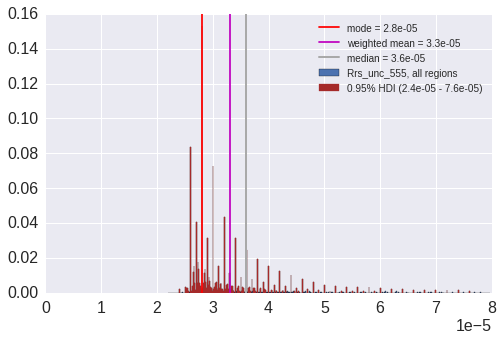

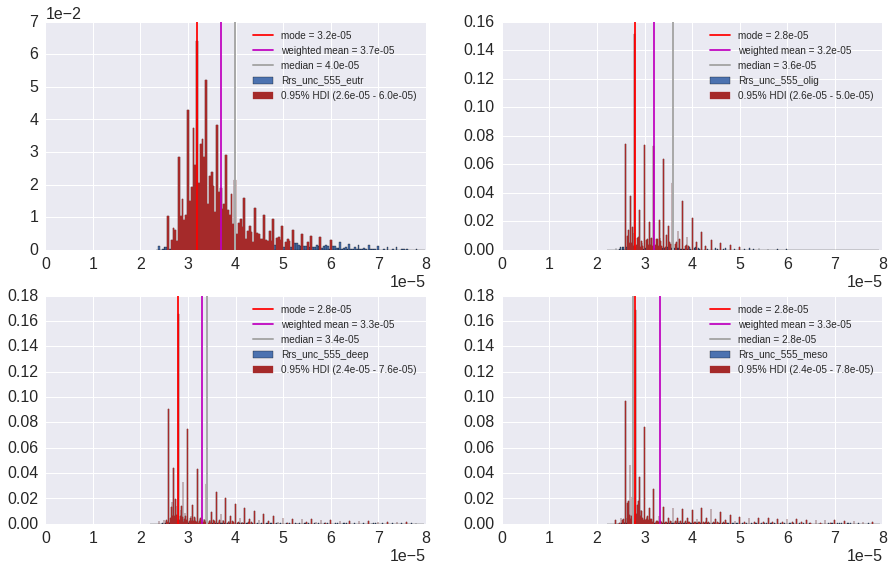

In [17]:
BAND=555
xlims=(0, 8e-5)
f1, ax1 = PlotUnmaskedDataDist(BAND, xlims=xlims)
f2, axs2 = PlotDataDistByReg(BAND, xlims=xlims)

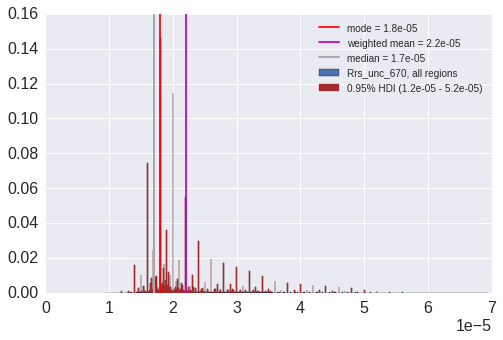

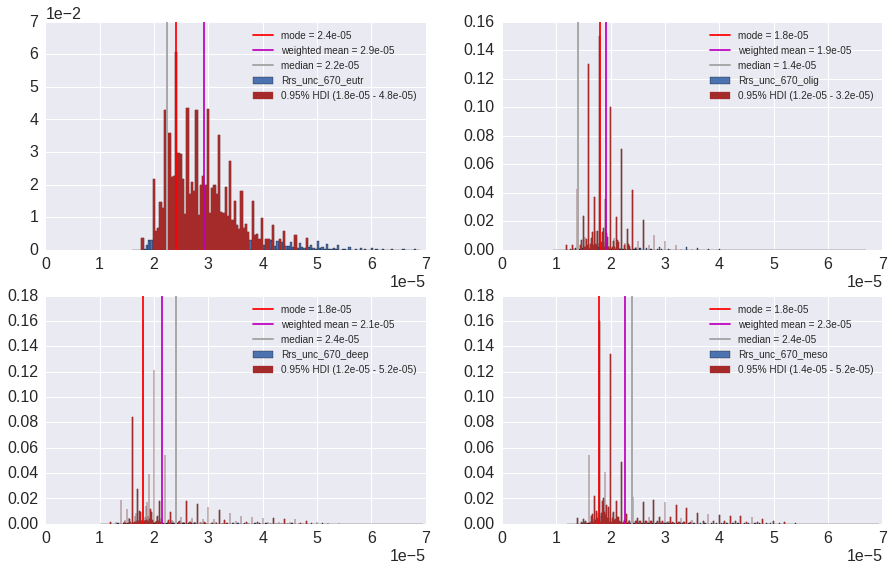

In [18]:
BAND=670
xlims=(0, 7e-5)
f1, ax1 = PlotUnmaskedDataDist(BAND, xlims=xlims)
f2, axs2 = PlotDataDistByReg(BAND, xlims=xlims)